# Advanced-Lane-Lines-P4

### Advanced Lane Finding Project

The goals / steps of this project are the following:

    * Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
    * Apply a distortion correction to raw images.
    * Use color transforms, gradients, etc., to create a thresholded binary image.
    * Apply a perspective transform to rectify binary image ("birds-eye view").
    * Detect lane pixels and fit to find the lane boundary.
    * Determine the curvature of the lane and vehicle position with respect to center.
    * Warp the detected lane boundaries back onto the original image.
    * Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

### Rubric Points
Here I will consider the rubric points individually and describe how I addressed each point in my implementation.

#### Camera Calibration

The code for this step is the first code cell of the IPython notebook in here below.

I started by preparing "object points (objpoints)", which will be the (x, y, z) coordinates of the chessboard corners in the world. Here I am assuming the chessboard is fixed on the (x, y) plane at z=0, such that the object points are the same for each calibration image. Thus, objp is just a replicated array of coordinates, and objpoints will be appended with a copy of it every time I successfully detect all chessboard corners in a test image (except for 3 images as noted in the o/p of first cell). imgpoints will be appended with the (x, y) pixel position of each of the corners in the image plane with each successful chessboard detection.

I then used the output objpoints and imgpoints to compute the camera calibration and distortion coefficients using the cv2.calibrateCamera() function. I applied this distortion correction to the test image using the cv2.undistort() function and obtained this result:

The o/p of the first cell shows one sample test image, undistorted image with chees board points marked and final image where the undistorted image has been wraped.


image size: (720, 1280, 3)
Warning! No chessboard found in image camera_cal/calibration1.jpg
Warning! No chessboard found in image camera_cal/calibration4.jpg
Warning! No chessboard found in image camera_cal/calibration5.jpg
Warning! No chessboard found in image camera_cal/GOPR0032.jpg


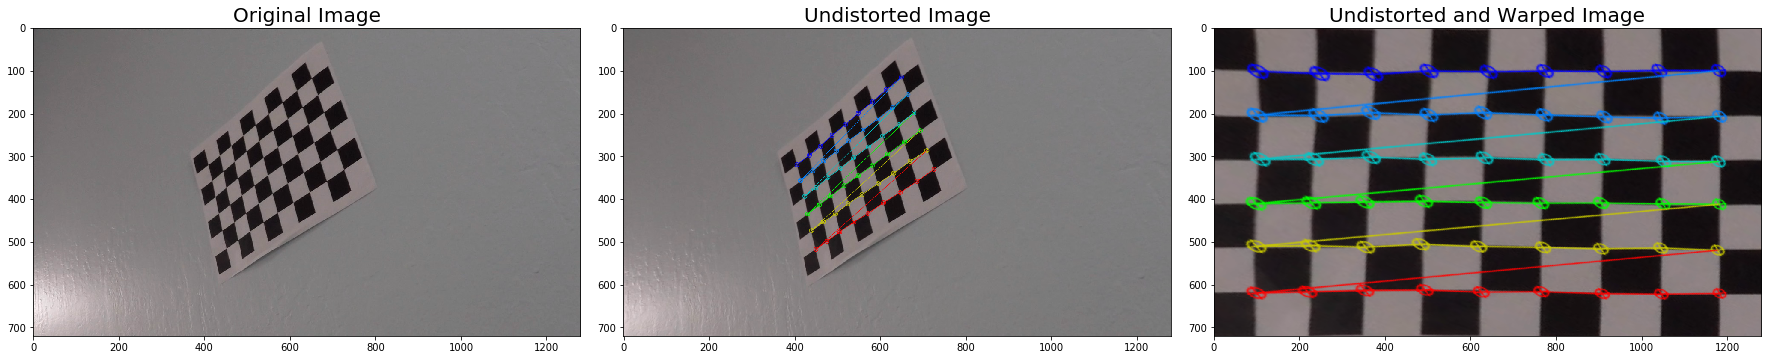

In [164]:
#importing required packages
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob

%matplotlib inline

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.


def camera_calibrate(nx, ny):
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((ny*nx,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob('camera_cal/*.jpg')
    image = cv2.imread(images[1])
    print("image size:", image.shape)
    img_size = (image.shape[1], image.shape[0])

    # Step through the list and search for chessboard corners
    for idx, fname in enumerate(images):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
            write_name = 'cam_callibrated_imgs/corners_found'+str(idx)+'.jpg'
            cv2.imwrite(write_name, img)
            #cv2.imshow('img', img)
            #cv2.waitKey(5)
        else:
            print('Warning! No chessboard found in image', fname)
    
    #print("objpoints:",objpoints)
    #print("imgpoints:", imgpoints)
    
    
    # Do camera calibration given object points and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
    
    # Save the camera calibration result for later use 
    dist_pickle = {}
    dist_pickle["mtx"] = mtx
    dist_pickle["dist"] = dist
    pickle.dump( dist_pickle, open( "camera_calibration_pickle.p", "wb" ) )
    
    return mtx, dist

def test_calibration(img, nx, ny, mtx, dist):
    
    # Use the OpenCV undistort() function to remove distortion
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    
    # Convert undistorted image to grayscale
    gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
    
    # Search for corners in the grayscaled image
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    if ret == True:
        # If we found corners, draw them! (just for fun)
        cv2.drawChessboardCorners(undist, (nx, ny), corners, ret)
        offset = 100 # offset for dst points
        # Grab the image shape
        img_size = (gray.shape[1], gray.shape[0])

        # For source points I'm grabbing the outer four detected corners
        #src = np.float32([corners[7],corners[47],corners[40],corners[0]])
        src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
        
        # For destination points, I'm arbitrarily choosing some points to be
        # a nice fit for displaying our warped result 
        # again, not exact, but close enough for our purposes
        dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                                     [img_size[0]-offset, img_size[1]-offset], 
                                     [offset, img_size[1]-offset]])
        #dst = np.float32([[1200, 100], [1200, 900],[100, 900],[100, 100]])
        
        # Given src and dst points, calculate the perspective transform matrix
        M = cv2.getPerspectiveTransform(src, dst)
        # Warp the image using OpenCV warpPerspective()
        warped = cv2.warpPerspective(undist, M, img_size)
        
        f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
        f.tight_layout()
        ax1.imshow(img)
        ax1.set_title('Original Image', fontsize=20)
        ax2.imshow(undist)
        ax2.set_title('Undistorted Image', fontsize=20)
        ax3.imshow(warped)
        ax3.set_title('Undistorted and Warped Image', fontsize=20)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    


# Calibration parameters.
nx = 9 # the number of inside corners in x
ny = 6 # the number of inside corners in y
#cshape = (nx, ny)
mtx, dist = camera_calibrate(nx, ny)

#print("mtx",mtx)
#print("dist",dist)

# Test calibration on some image.
# Read in an image
img = cv2.imread('camera_cal/calibration13.jpg')
test_calibration(img, nx, ny, mtx, dist)

# Read in the saved camera matrix and distortion coefficients
# These are the arrays you calculated using cv2.calibrateCamera()
#dist_pickle = pickle.load( open( "camera_calibration_pickle.p", "rb" ) )
#mtx = dist_pickle["mtx"]
#dist = dist_pickle["dist"]



### Pipeline (single images)

Before I started implementing all the required processing on the actual images to detect the lanes, I have written down all the required pipeline functions that I would be needing to implement all the requirments of the project.



In [2]:
# Define All Required PipleLine Functions

#importing required packages
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob

kernel_size = 5

def draw_pw_lines(img,pts,color):
    # draw lines
    pts = np.int_(pts)
    for i in range(10):
        x1 = pts[0][i][0]
        y1 = pts[0][i][1]
        x2 = pts[0][i+1][0]
        y2 = pts[0][i+1][1]
        cv2.line(img, (x1, y1), (x2, y2),color,50)
        

def undistort_image(img, mtx, dist):
    # Undistort image
    undist_img = cv2.undistort(img, mtx, dist, None, mtx)
    return undist_img
def gaussian_blur(img, kernel=5):
    # Apply Gaussian Blur
    blur = cv2.GaussianBlur(img,(kernel,kernel),0)
    return blur

    
def GaussianC_Adaptive_Threshold(img,kernel,cut_val):
    # Apply Gaussian adaptive thresholding
    img_cut = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,kernel,cut_val)
    return img_cut

def warp_image(img,src,dst,img_size, inverse='false'):
    # Apply perspective transform
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    if inverse=='false' :
        warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    else : 
        warped = cv2.warpPerspective(img, Minv, img_size, flags=cv2.INTER_LINEAR)
    

    return warped,M,Minv

def sobel_combined(image):
    # Apply combined sobel filter
    img_g_mag = mag_thresh(image,3,(20,150))
    img_d_mag = dir_threshold(image,3,(.6,1.1))
    img_abs_x = abs_sobel_thresh(image,'x',5,(50,200))
    img_abs_y = abs_sobel_thresh(image,'y',5,(50,200))
    sobel_combined = np.zeros_like(img_d_mag)
    sobel_combined[((img_abs_x == 1) & (img_abs_y == 1)) | \
               ((img_g_mag == 1) & (img_d_mag == 1))] = 1
    return sobel_combined


def color_mask(hsv,low,high):
    # Return mask from HSV 
    mask = cv2.inRange(hsv, low, high)
    return mask

def apply_color_mask(hsv,img,low,high):
    # Apply color mask to image
    mask = cv2.inRange(hsv, low, high)
    res = cv2.bitwise_and(img,img, mask= mask)
    return res

def moving_average(a, n=3):
    # Moving average
    ret = np.cumsum(a, axis=0, dtype=float)
    print("ret:",ret)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n


def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    # Apply threshold
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return binary_output

def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    # Calculate gradient magnitude and Apply threshold
    
    gray = image

    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    #gradmag = np.uint8(gradmag/scale_factor) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    #mag_binary = np.zeros_like(gradmag)
    mag_binary = 0*gradmag
    #print("mag_binary size:", mag_binary.shape)
    mag_binary[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    
    return mag_binary

def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction and Apply threshold
    
    gray = image
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    dir_binary =  np.zeros_like(absgraddir)
    dir_binary[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    
    return dir_binary

def color_threshold(image, sthresh=(0,255), vthresh=(0,255)):
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= sthresh[0]) & (s_channel <= sthresh[1])  ] = 1

    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    v_channel = hsv[:,:,2]
    v_binary = np.zeros_like(v_channel)
    v_binary[(v_channel >= vthresh[0]) & (v_channel <= vthresh[1])  ] = 1

    output = np.zeros_like(s_channel)
    output[(s_binary == 1) & (v_binary == 1)] = 1
    return output

def sobel_combined_channel(image, s_thresh=(170, 255), sx_thresh=(20, 100), ksize = 9) :
    # Choose a Sobel kernel size
    #ksize = 9 # Choose a larger odd number to smooth gradient measurements

    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=sx_thresh)
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=sx_thresh)
    mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=sx_thresh)
    dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0.7, 1.3))
    
    #print("gradx:", gradx.shape)
    #print("grady:", grady.shape)
    #print("mag_binary:", mag_binary.shape)
    #print("dir_binary:", dir_binary.shape)
    
    sxbinary = np.zeros_like(image)
    sxbinary[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    #sxbinary[ ((grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(image)
    s_binary[(image >= s_thresh[0]) & (image <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    return color_binary, combined_binary
    
def window_mask(width, height, img_ref, center, level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width)):min(int(center+width),img_ref.shape[1])] = 1 
    #print("output:", output)
    return output
    
    


### 1. Undistort image.
First I load the original image and undistort it. Panels below present the original image, and undistorted image. As can be seen, the undistorted image is different from the original image.

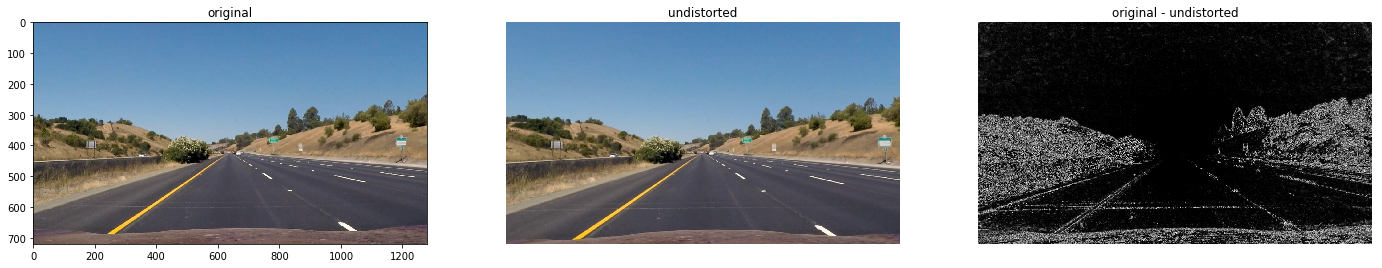

In [52]:
#importing required packages
import pickle
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline


# Read in the saved camera matrix and distortion coefficients
# These are the arrays you calculated using cv2.calibrateCamera()
dist_pickle = pickle.load( open( "camera_calibration_pickle.p", "rb" ) )
mtx_camera = dist_pickle["mtx"]
dist_camera = dist_pickle["dist"]

# Load I/P Image:
#image = cv2.imread('test_images/test2.jpg')
image = mpimg.imread('test_images/straight_lines1.jpg')
image_ud = undistort_image(image, mtx_camera , dist_camera )

plt.figure(figsize=(24, 9))
plt.subplot(1,3,1)
plt.imshow(image)
#plt.axis('off');
plt.title('original')
plt.subplot(1,3,2)
plt.imshow(image_ud)
plt.title('undistorted')
plt.axis('off');
plt.subplot(1,3,3)
plt.imshow(np.sum((image-image_ud)**2,axis=2),cmap='gray')
#plt.imshow(image_ud,cmap='gray')
plt.title('original - undistorted')
plt.axis('off');


### 2. Apply perspective transform
I then applied perspective transform to get bird eye-view.Assumpition here is that the road is flat. Hence the converging lanes that are displayed in normal view is converted into birds eye view so that the lanes appare parrllel.

In [53]:
image = image_ud
img_size = np.shape(image)
print("img_size:",img_size)

img_size: (720, 1280, 3)


img_size: (1280, 720)


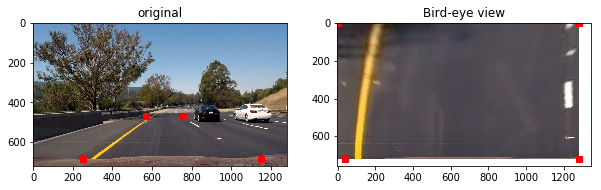

In [12]:
img_size1 = np.shape(image)
img_size = (image.shape[1], image.shape[0])
#print("img_size1:",img_size1)
print("img_size:",img_size)

# work on defining perspective transformation area
img_size = (image.shape[1], image.shape[0])
bot_width = .76 # percent of bottom trapizoid height
mid_width = .16 # percent of middle trapizoid height
height_pct = .66 # percent for trapizoid height
bottom_trim = .935 # percent from top to bottom to avoid car hood 
#src = np.float32([[image.shape[1]*(.5-mid_width/2),image.shape[0]*height_pct],[image.shape[1]*(.5+mid_width/2),image.shape[0]*height_pct],[image.shape[1]*(.5+bot_width/2),image.shape[0]*bottom_trim],[image.shape[1]*(.5-bot_width/2),image.shape[0]*bottom_trim]])
#offset = img_size[0]*.25
#dst = np.float32([[offset, 0], [img_size[0]-offset, 0],[img_size[0]-offset, img_size[1]], [offset ,img_size[1]]])

src = np.float32([[568, 470],[755, 470],[1150, 685],[250, 685]])
dst = np.float32([[0, 0], [1280, 0], [1280, 720],[40, 720]])

warped,M_warp,Minv_warp = warp_image(image,src,dst,(img_size[0],img_size[1]))

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(image,cmap='gray')
for i in range(4):
    plt.plot(src[i][0],src[i][1],'rs')
plt.title('original')
#plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(warped,cmap='gray')
for i in range(4):
    plt.plot(dst[i][0],dst[i][1],'rs')
    
plt.title('Bird-eye view')
#plt.axis('off');

This resulted in the following source and destination points:

Source	    Destination
585, 460	320, 0
203, 674	320, 720
1127, 674	960, 720
695, 460	960, 0


### 3. Apply color mask
Before I apply the Sobel Operation and Color space(Color and Gradiaent Threshold), I will first apply color masks to identify yellow and white lane markings in the bird-eye view image.

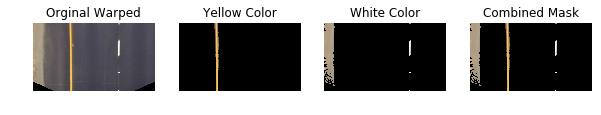

In [76]:
# Refference : http://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_colorspaces/py_colorspaces.html
# Refference : http://docs.opencv.org/trunk/d0/d86/tutorial_py_image_arithmetics.html

image_HSV = cv2.cvtColor(warped,cv2.COLOR_RGB2HSV)

yellow_hsv_low  = np.array([ 0,  100,  100])
yellow_hsv_high = np.array([ 80, 255, 255])

white_hsv_low  = np.array([ 0,   0,   160])
white_hsv_high = np.array([ 255,  80, 255])

yellow_mask = apply_color_mask(image_HSV,warped,yellow_hsv_low,yellow_hsv_high)
white_mask = apply_color_mask(image_HSV,warped,white_hsv_low,white_hsv_high)

mask_lane = cv2.bitwise_or(yellow_mask,white_mask)

plt.figure(figsize=(10,4))
plt.subplot(1,4,1)
plt.imshow(warped)
plt.title('Orginal Warped')
plt.axis('off')
plt.subplot(1,4,2)
plt.imshow(yellow_mask)
plt.title('Yellow Color')
plt.axis('off')
plt.subplot(1,4,3)
plt.imshow(white_mask)
plt.title('White Color')
plt.axis('off')
plt.subplot(1,4,4)
plt.imshow(mask_lane, cmap='gray')
plt.title('Combined Mask')
plt.axis('off');

### 4. Apply Sobel filters
Next I will apply sobel filters to the L and S channels of the image in both HLS and HSV color space. Chose various L and S channels because in L and S channels, the lanes were more prominent. I chose this color scheme after a lot of tiral and error in the lab sessions.

s_channel Size: (720, 1280)


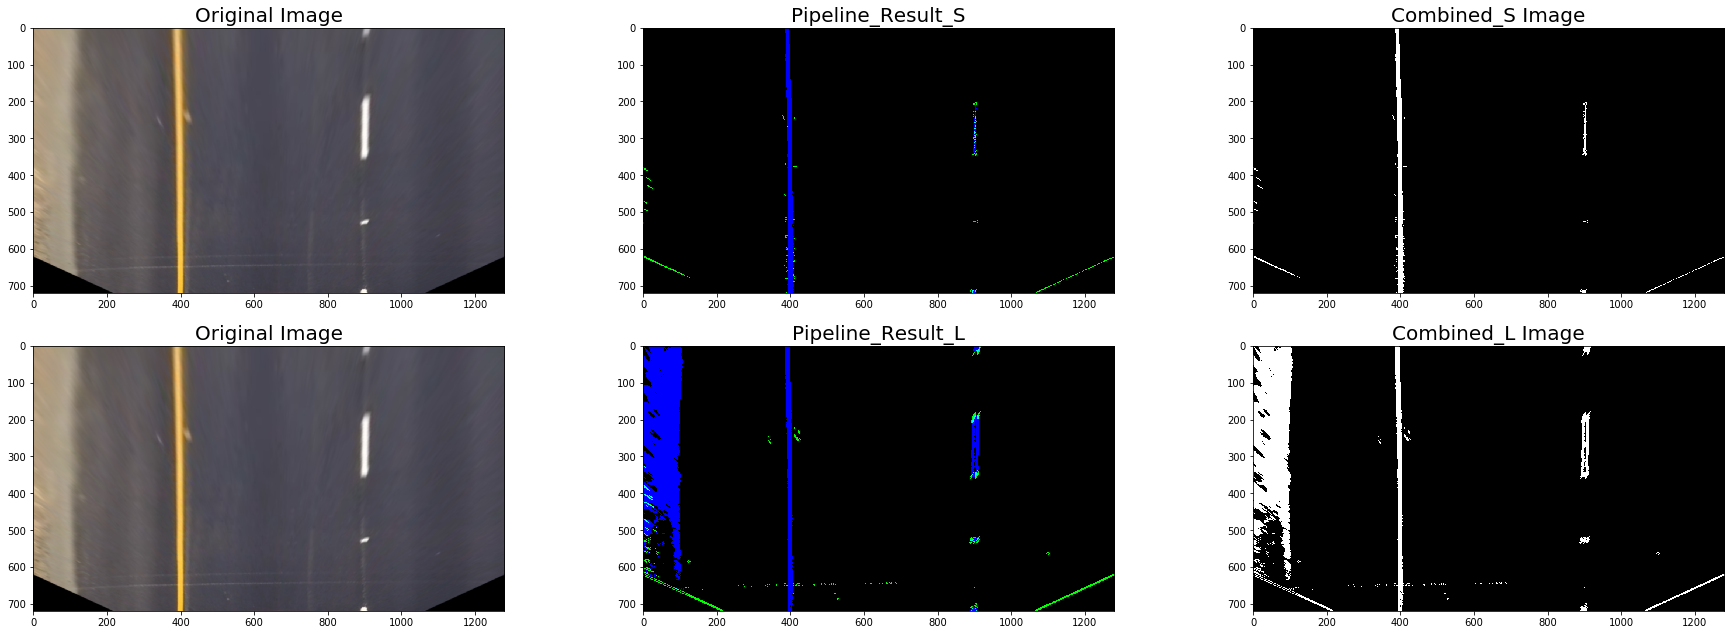

In [84]:
#### Apply sobel filters to L and S channels
image = gaussian_blur(warped, kernel=5)

# Convert to HLS color space and separate the V channels
image_HLS = cv2.cvtColor(warped, cv2.COLOR_RGB2HLS).astype(np.float)
h_channel = image_HLS[:,:,0]
l_channel = image_HLS[:,:,1]
s_channel = image_HLS[:,:,2]
print("s_channel Size:", s_channel.shape)

# Convert to HSV color space and separate the V channels
image_HSV = cv2.cvtColor(warped, cv2.COLOR_RGB2HSV).astype(np.float)
h_channel2 = image_HSV[:,:,0]
s_channel2 = image_HSV[:,:,1]
v_channel2 = image_HSV[:,:,2]

result, wraped_s = sobel_combined_channel(s_channel, s_thresh=(170, 255), sx_thresh=(20, 150), ksize = 9)
result2, wraped_l = sobel_combined_channel(l_channel, s_thresh=(150, 250), sx_thresh=(20, 150), ksize = 9)
#result2, wraped_l = sobel_combined_channel(s_channel2, s_thresh=(50, 200), sx_thresh=(20, 150), ksize = 9)

#image_cmb = gaussian_blur(combined_result,3)

# Plot the result
f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(24, 9))
#f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(result)
ax2.set_title('Pipeline_Result_S', fontsize=20)
ax3.imshow(wraped_s, cmap='gray')
ax3.set_title('Combined_S Image', fontsize=20)

ax4.imshow(image)
ax4.set_title('Original Image', fontsize=20)
ax5.imshow(result2)
ax5.set_title('Pipeline_Result_L', fontsize=20)
ax6.imshow(wraped_l, cmap='gray')
ax6.set_title('Combined_L Image', fontsize=20)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)





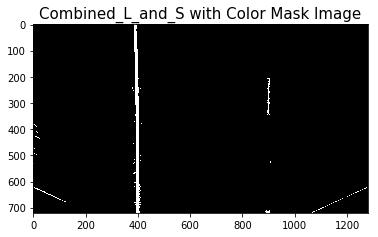

In [85]:
#### Combine Sobel filters from L and S channels.

#wraped_comb_img = cv2.bitwise_or(wraped_s,wraped_l)
wraped_comb_img = wraped_s
#wraped_comb_img = gaussian_blur(image_cmb,3)
plt.imshow(wraped_comb_img,cmap='gray')
plt.title('Combined_L_and_S with Color Mask Image', fontsize=15)

From above, I get good representation of lane masks. However, these masks are based on yellow and white colors and sobel filter calculations. If there are additional drawings or markings on the road, this algorithm will not give two neat lines as above, hence will therefore need to perform additional analysis to isolate the lane loactions.


# 5. Identify Lanes
Hence in-order to perform additional analysis to isolate the left and right lanes from above. For this we will take bottom half of the image and compute histogram of distribution of pixel intensities to identify the peaks that will represnt the two lane lines

### Line Finding Method: Peaks in a Histogram

After applying calibration, thresholding, and a perspective transform to a road image, we have a binary image where the lane lines stand out clearly. However, we still need to decide explicitly which pixels are part of the lines and which belong to the left line and which belong to the right line.

I first take a histogram along all the columns in the lower half of the image as show below and then calculate the sum of all the points along vertical axis:

img.shape[0]: 720
img.shape[] : (720, 1280)


/Users/vijaynaik/anaconda/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/vijaynaik/anaconda/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:10: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(0, 1280)

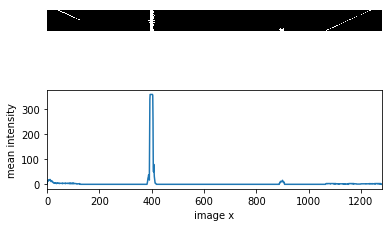

In [92]:
wraped_comb_img1 = np.copy(wraped_comb_img)
print("img.shape[0]:",wraped_comb_img.shape[0])
print("img.shape[] :",wraped_comb_img.shape)
histogram = np.sum(wraped_comb_img1[wraped_comb_img.shape[0]/2:,:], axis=0)
#histogram = np.mean(wraped_comb_img1[wraped_comb_img.shape[0]/2:,:], axis=0)

#print("histogram:",histogram)

plt.subplot(2,1,1)
plt.imshow(wraped_comb_img[img_size[0]/2:,:],cmap='gray')
plt.axis('off')
plt.subplot(2,1,2)
#plt.plot(histogram>.05)
plt.plot(histogram)
plt.xlabel('image x')
plt.ylabel('mean intensity')
plt.xlim(0,img_size[0])
#plt.xlim(0, 1280)
#plt.ylim(720, 0)

Once we get the two peaks as identified above, we will place a window of width 50 centered at the peak location in the bottom 1/8th of the image and slide it up and incrementally compute window locations based on location of peaks. This is illustrated in the code below.

 
 ### Detection of Lane Pixels

 Detect lane pixels and fit to find the lane boundary and 
 Determine the curvature of the lane and vehicle position with respect to center.
 
All the bits that I had above has been conslidated below and imaplmented as one unite on all the test images so that I could generalize the solution and paramters to match the use case on all the test images instead of just one.

img_size: (720, 1280, 3)


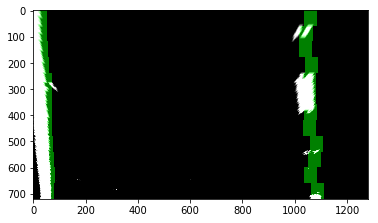

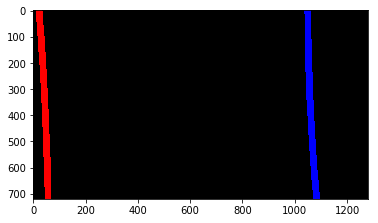

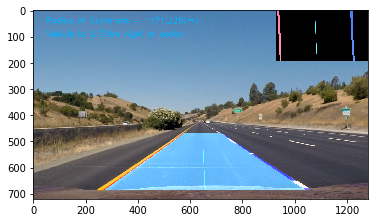

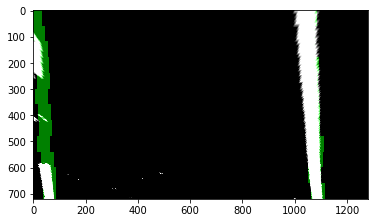

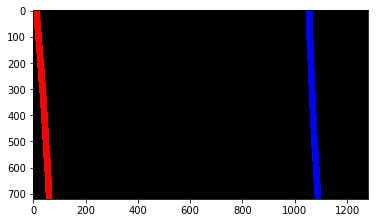

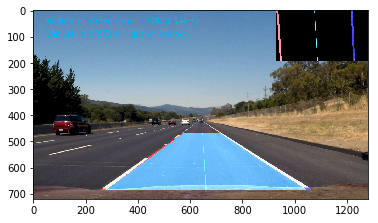

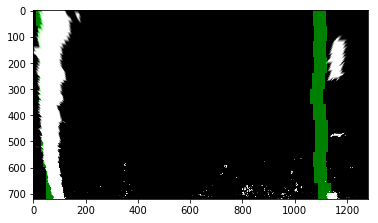

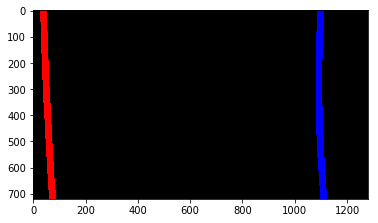

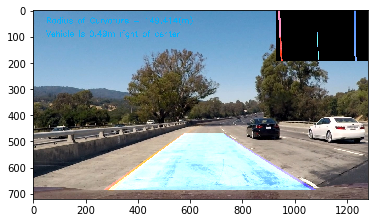

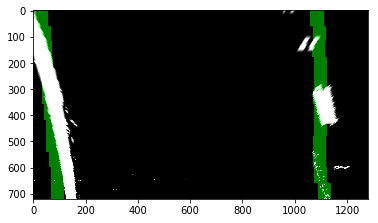

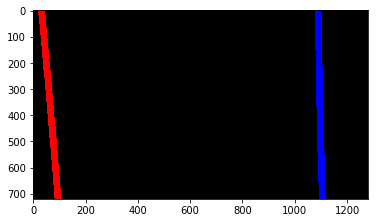

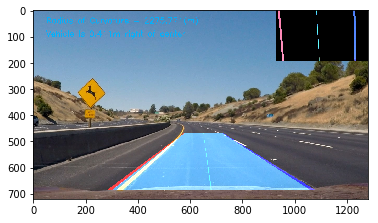

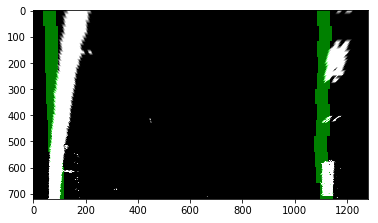

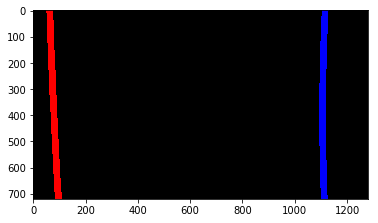

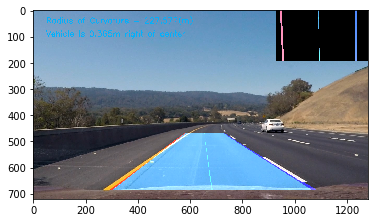

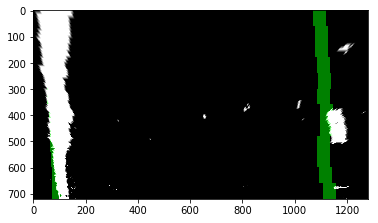

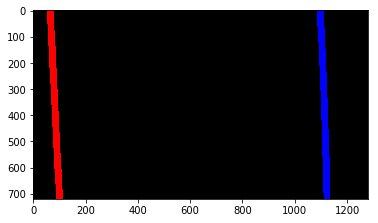

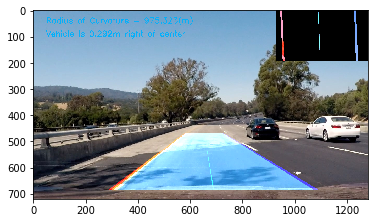

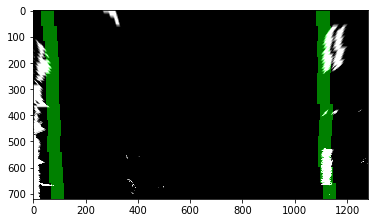

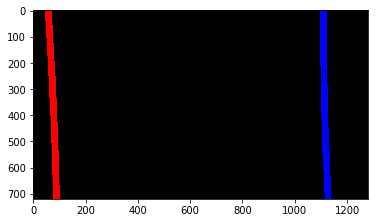

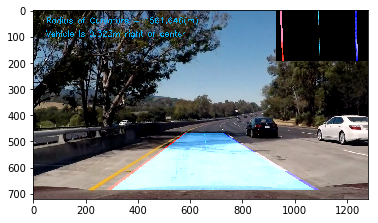

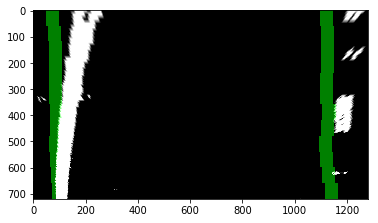

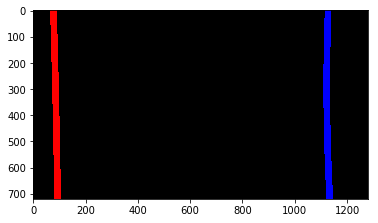

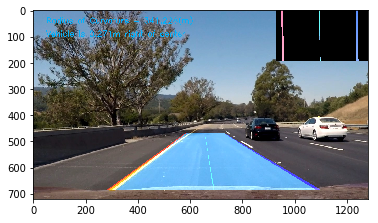

In [11]:
###### Lets Re-write all the functions now to go through all the test images in a loop

#importing required packages
import pickle
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
from tracker import tracker

%matplotlib inline


# Read in the saved camera matrix and distortion coefficients
# These are the arrays you calculated using cv2.calibrateCamera()
dist_pickle = pickle.load( open( "camera_calibration_pickle.p", "rb" ) )
mtx_camera = dist_pickle["mtx"]
dist_camera = dist_pickle["dist"]

#print("mtx_camera:", mtx_camera)
#print("dist_camera:",dist_camera)

# Make a list of calibration images
images = glob.glob('test_images/*.jpg')
image = cv2.imread(images[1])
#print("image size:", image.shape)
img_size = np.shape(image)
print("img_size:",img_size)

#Points used to find left and right lanes
#rightx = []
#leftx = []

window_width = 25
window_height = 80
window = np.ones(window_height)
window_centorids_good = []    
#Set the function to do the over all tracking of lanes
#curve_centers = tracker(Mywindow_width = window_width, Mywindow_height = window_height, Mymargin = 25, My_ym = 10/270, My_xm = 3.7/1100, Mysmooth_factor = 15)
    

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    image = mpimg.imread(fname)
    
    # Un-distort the images based on Camera Cali done
    undist_img = undistort_image(image, mtx_camera , dist_camera ) 
    
    #Apply Sobel filters and Color Masks
    # process image and generate binary pixel of interests
    ##r_channel = undist_img[:,:,0]
    ##preprocessImage = np.zeros_like(undist_img[:,:,0])
    ##gradx = abs_sobel_thresh(undist_img, orient='x', thresh=(25,150)) # 12 , 25
    ##grady = abs_sobel_thresh(undist_img, orient='y', thresh=(10,150)) # 25 , 10
    c_binary = color_threshold(undist_img, sthresh=(100,255), vthresh=(50,255)) #50, 100,255
    ##preprocessImage[((gradx == 1) & (grady == 1) | (c_binary == 1) )] = 255
    
    
    # Generate binary thresholded images
    b_channel = cv2.cvtColor(undist_img, cv2.COLOR_RGB2Lab)[:,:,2]
    l_channel = cv2.cvtColor(undist_img, cv2.COLOR_RGB2LUV)[:,:,0]  
    s_channel = cv2.cvtColor(undist_img, cv2.COLOR_RGB2HLS)[:,:,2]
    
    
    # Set the upper and lower thresholds for the b channel
    b_thresh_min = 145 #145
    b_thresh_max = 200 #200
    b_binary = np.zeros_like(b_channel)
    b_binary[(b_channel >= b_thresh_min) & (b_channel <= b_thresh_max)] = 1 #b_channel
    
    # Set the upper and lower thresholds for the l channel
    l_thresh_min = 215
    l_thresh_max = 255
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh_min) & (l_channel <= l_thresh_max)] = 1 #l_channel

    preprocessImage = np.zeros_like(b_binary)
    preprocessImage[(l_binary == 1) | (b_binary == 1)| (c_binary == 1)] = 255
    
    
    
    #plt.imshow(preprocessImage,cmap='gray')
    #plt.show()
    
    #Apply perspective transform to get the Brids eye-view
    # work on defining perspective transformation area
    img_size = (image.shape[1], image.shape[0])
    bot_width = .76 # percent of bottom trapizoid height .76
    mid_width = .08 # percent of middle trapizoid height .16
    height_pct = .63 # percent for trapizoid height .70
    bottom_trim = .935 # percent from top to bottom to avoid car hood .935
    #src = np.float32([[image.shape[1]*(.5-mid_width/2),image.shape[0]*height_pct],[image.shape[1]*(.5+mid_width/2),image.shape[0]*height_pct],[image.shape[1]*(.5+bot_width/2),image.shape[0]*bottom_trim],[image.shape[1]*(.5-bot_width/2),image.shape[0]*bottom_trim]])
    #offset = img_size[0]*.25
    #dst = np.float32([[offset, 0], [img_size[0]-offset, 0],[img_size[0]-offset, img_size[1]], [offset ,img_size[1]]])
    #warped,M_warp,Minv_warp = warp_image(preprocessImage,src,dst,(img_size[0],img_size[1]))
    
    src = np.float32([[568, 470],[750, 470],[1150, 685],[250, 685]])
    dst = np.float32([[0, 0], [1280, 0], [1280, 720],[40, 720]])
    
    # perform the transform
    M = cv2.getPerspectiveTransform(src,dst)
    Minv = cv2.getPerspectiveTransform(dst,src)
    warped = cv2.warpPerspective(preprocessImage,M,img_size,flags=cv2.INTER_LINEAR)

    #plt.imshow(warped,cmap='gray')
    #plt.show()
    
    #window_width = 25
    #window_height = 80
    #window = np.ones(window_height)
    
    #Set the function to do the over all tracking of lanes
    curve_centers = tracker(Mywindow_width = window_width, Mywindow_height = window_height, Mymargin = 25, My_ym = 10/270, My_xm = 3.7/1100, Mysmooth_factor = 25)
    window_centorids = curve_centers.find_window_centroids(warped)
    
    #print("window_centorids", window_centorids)
    print("lenght of window_centorids:", len(window_centorids))
    
    window_centorids_avg = np.mean(window_centorids[:], axis=0)
    #print("window_centorids_avg", window_centorids_avg)
    
    leftx_avg = int(window_centorids_avg[0])
    rightx_avg = int(window_centorids_avg[1])
    
    if ((rightx_avg - leftx_avg) < 1000 or (rightx_avg - leftx_avg) > 1100):
        print("BAD Lane")
        window_centorids = window_centorids_good[-1]
        #print("From Bad window_centorids:", window_centorids)
    else:
        print("Good Lane")
        window_centorids_good.append(window_centorids)
        #window_centorids_good = window_centorids
        #print("window_centorids_good:",window_centorids_good)
    
    
    #Points used to draw all the left and right windows
    l_points = np.zeros_like(warped)
    r_points = np.zeros_like(warped)
    
    #Points used to find left and right lanes
    rightx = []
    leftx = []
    
    #go through each level and draw the windows
    for level in range(0, len(window_centorids)):
        
        #print("inside for loop window_centorids:::",window_centorids[level][0])
        #window_mask is the function to draw the widow areas
        l_mask = window_mask(window_width, window_height, warped, window_centorids[level][0],level)
        r_mask = window_mask(window_width, window_height, warped, window_centorids[level][1],level)
        
        #add center values found in frame to the list of lane points per left, right
        leftx.append(window_centorids[level][0])
        rightx.append(window_centorids[level][1])
        
        #Add graphic points from the window mask here to total pixels found
        l_points[(l_points == 255) | ((l_mask == 1))] = 255
        r_points[(r_points == 255) | ((r_mask == 1))] = 255
        
    # Draw the results
    # drawing the graphic overlay to represents the results found for tracking window centers
    template = np.array(r_points + l_points, np.uint8) # add both left n right window pixel together
    zero_channel = np.zeros_like(template) # Create a zero color channel
    template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixel green
    warpage = np.array(cv2.merge((warped,warped,warped)),np.uint8)# making orginal road pixels 3 color channel
    #warpage=np.dstack((warped, warped, warped))*255
    result2 = cv2.addWeighted(np.uint8(warpage), 1, template, 0.5, 0.0)
    
    plt.imshow(result2,cmap='gray')
    plt.show()
        
    #Fit the lane boundries in the left and right center postions found
    yvals = range(0,warped.shape[0])
    res_yvals = np.arange(warped.shape[0]-(window_height/2),0,-window_height)
    
    
    
    left_fit = np.polyfit(res_yvals, leftx, 2)
    left_fitx = left_fit[0]*yvals*yvals + left_fit[1]*yvals + left_fit[2]
    left_fitx = np.array(left_fitx, np.int32)
    
    right_fit = np.polyfit(res_yvals, rightx, 2)
    right_fitx = right_fit[0]*yvals*yvals + right_fit[1]*yvals + right_fit[2]
    right_fitx = np.array(right_fitx, np.int32)
    
    # used to find center curve
    curve_xpts = [(right_fitx[0]+left_fitx[0])/2,(right_fitx[len(right_fitx)/2]+left_fitx[len(left_fitx)/2])/2,(right_fitx[-1]+left_fitx[-1])/2]
    curve_ypts = [yvals[0],yvals[(int)(len(yvals)/2)],yvals[-1]]
    curve_fit = np.polyfit(curve_ypts, curve_xpts, 2)
    curve_fitx = curve_fit[0]*yvals*yvals + curve_fit[1]*yvals+ curve_fit[2]
    
    
    # used to format everything so its ready for cv2 draw functions
    left_lane = np.array(list(zip(np.concatenate((left_fitx-window_width/2,left_fitx[::-1]+window_width/2), axis=0),np.concatenate((yvals,yvals[::-1]),axis=0))),np.int32)
    right_lane = np.array(list(zip(np.concatenate((right_fitx-window_width/2,right_fitx[::-1]+window_width/2), axis=0),np.concatenate((yvals,yvals[::-1]),axis=0))),np.int32)
    inner_lane = np.array(list(zip(np.concatenate((left_fitx+window_width/2,right_fitx[::-1]-window_width/2), axis=0),np.concatenate((yvals,yvals[::-1]),axis=0))),np.int32)
    curve_pts = np.array([list(zip(curve_fitx,yvals))],np.int32)
    
    
    # draw lane lines, middle curve, road background on two different blank overlays
    road = np.zeros_like(image)
    road_bkg = np.zeros_like(image)
    cv2.fillPoly(road,[left_lane],color=[255,0,0]) #left_lane
    cv2.fillPoly(road,[right_lane],color=[0,0,255]) #right_lane
    
    plt.imshow(road,cmap='gray')
    plt.show()
    write_name = 'processed_images/polyfit_img'+str(idx)+'.jpg'
    cv2.imwrite(write_name, road)
    
    
    
    cv2.polylines(road,[curve_pts],isClosed=False, color=[5, 176, 249], thickness=3)
    cv2.fillPoly(road_bkg,[inner_lane],color=[38, 133, 197])
    #cv2.fillPoly(road_bkg,[left_lane],color=[255,255,255])
    #cv2.fillPoly(road_bkg,[right_lane],color=[255,255,255])
    
    
    
    #road_warped = cv2.warpPerspective(road,Minv_warp,img_size,flags=cv2.INTER_LINEAR)
    road_warped_bkg = cv2.warpPerspective(road_bkg,Minv,img_size,flags=cv2.INTER_LINEAR)
    road_warped,M_warp,Minv_warp = warp_image(road,src,dst,(img_size[0],img_size[1]), inverse='true')
    result2_bkg = cv2.addWeighted(road_warped_bkg, 1, road_warped, 1, 0.0)
    result = cv2.addWeighted(undist_img, 1, result2_bkg, 0.9, 0.0)
    
    
    
    # calcuate the middle line curvature
    ym_per_pix = curve_centers.ym_per_pix # meters per pixel in y dimension
    xm_per_pix = curve_centers.xm_per_pix # meteres per pixel in x dimension
    curve_fit_cr = np.polyfit(np.array(curve_ypts,np.float32)*ym_per_pix, np.array(curve_xpts,np.float32)*xm_per_pix, 2)
    curverad = ((1 + (2*curve_fit_cr[0]*curve_ypts[-1]*ym_per_pix + curve_fit_cr[1])**2)**1.5) /np.absolute(2*curve_fit_cr[0])
    #curve_centers.curvatures.append(curverad)
    #curverad = curve_centers.SmoothCurve()

    # calculate the offset of the car on the road
    camera_center = (left_fitx[-1] + right_fitx[-1])/2
    center_diff = (camera_center-warped.shape[1]/2)*xm_per_pix
    side_pos = 'left'
    if center_diff <= 0:
        side_pos = 'right'
    
    
    # draw the text showing curvature, offset, and speed
    cv2.putText(result,'Radius of Curvature = '+str(round(curverad,3))+'(m)',(50,50) , cv2.FONT_HERSHEY_SIMPLEX, 1,(255, 255, 0),2)
    cv2.putText(result,'Vehicle is '+str(abs(round(center_diff,3)))+'m '+side_pos+' of center',(50,100) , cv2.FONT_HERSHEY_SIMPLEX, 1,(255, 255, 0),2)

    
    # Super impose the polyfit lines on the final image
    
    r = 350.0 / road.shape[1]
    dim = (350, int(road.shape[0] * r))
 
    # perform the actual resizing of the image and show it
    road_resized = cv2.resize(road, dim, interpolation = cv2.INTER_AREA)

    # I want to put logo on top-left corner, So I create a ROI
    rows,cols,channels = road_resized.shape
    
    roi = result[0:rows, result.shape[1]-cols:result.shape[1] ]
    #roi = img1[0:rows, 600:700 ]

    # Now create a mask of road image and create its inverse mask also
    img2gray = cv2.cvtColor(road_resized,cv2.COLOR_BGR2GRAY)
    ret, mask = cv2.threshold(img2gray, 10, 255, cv2.THRESH_BINARY)
    mask_inv = cv2.bitwise_not(mask)
    # Now black-out the area of road in ROI
    img1_bg = cv2.bitwise_and(roi,roi,mask = mask)
    # Take only region of road from road image.
    img2_fg = cv2.bitwise_and(road_resized,road_resized,mask = mask)
    # Put logo in ROI and modify the main image
    dst = cv2.add(img1_bg,img2_fg)
    #img1[0:rows, 600:700 ] = dst
    result[0:rows, result.shape[1]-cols:result.shape[1] ] = dst
    #cv2.imshow('res',img1)

    
    
    
    plt.imshow(result,cmap='gray')
    plt.show()

    #write_name = 'processed_images/final_img'+str(idx)+'.jpg'
    #cv2.imwrite(write_name, result)


### Pipeline (video)

Below code is the reproduction of the same code used above for the images. I have re-used the some of the code for the vidoes inorder to detect the lanes and radius of curvature. The Output of the videos has been uploaded along with the project report. 


In [8]:
#### Let use all the above code on the Video files #######
#Coping all the code from the above cells so its easy to refer

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import numpy as np
import cv2
import pickle
import glob
from tracker import tracker


# Read in the saved camera matrix and distortion coefficients
# These are the arrays you calculated using cv2.calibrateCamera()
dist_pickle = pickle.load( open( "camera_calibration_pickle.p", "rb" ) )
mtx_camera = dist_pickle["mtx"]
dist_camera = dist_pickle["dist"]

window_width = 40
window_height = 120
window = np.ones(window_height)
window_centorids_good = [] 

#Set the function to do the over all tracking of lanes
curve_centers = tracker(Mywindow_width = window_width, Mywindow_height = window_height, Mymargin = 25, My_ym = 30/720, My_xm = 3.7/1100, Mysmooth_factor = 25)
    

def process_image(image):
    
    # Un-distort the images based on Camera Cali done
    undist_img = undistort_image(image, mtx_camera , dist_camera ) 
    
    #Apply Sobel filters and Color Masks
    # process image and generate binary pixel of interests
    r_channel = undist_img[:,:,0]
    ##preprocessImage = np.zeros_like(undist_img[:,:,0])
    gradx = abs_sobel_thresh(undist_img, orient='x', thresh=(25,150)) # 12 , 25
    grady = abs_sobel_thresh(undist_img, orient='y', thresh=(10,150)) # 25 , 10
    c_binary = color_threshold(undist_img, sthresh=(50,255), vthresh=(100,255)) #50, 100,255
    ##preprocessImage[((gradx == 1) & (grady == 1) | (c_binary == 1) )] = 255
    
    
    # Generate binary thresholded images
    b_channel = cv2.cvtColor(undist_img, cv2.COLOR_RGB2Lab)[:,:,2]
    l_channel = cv2.cvtColor(undist_img, cv2.COLOR_RGB2LUV)[:,:,0]  
    s_channel = cv2.cvtColor(undist_img, cv2.COLOR_RGB2HLS)[:,:,2]
    
    
    # Set the upper and lower thresholds for the b channel
    b_thresh_min = 145 #145
    b_thresh_max = 200 #200
    b_binary = np.zeros_like(b_channel)
    b_binary[(b_channel >= b_thresh_min) & (b_channel <= b_thresh_max)] = 1 #b_channel
    
    # Set the upper and lower thresholds for the l channel
    l_thresh_min = 215
    l_thresh_max = 255
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh_min) & (l_channel <= l_thresh_max)] = 1 #l_channel

    r_thresh_min = 215
    r_thresh_max = 255
    r_binary = np.zeros_like(r_channel)
    r_binary[(r_channel >= r_thresh_min) & (r_channel <= r_thresh_max)] = 1 #r_channel
    
    preprocessImage = np.zeros_like(b_binary)
    #preprocessImage[(l_binary == 1) | (b_binary == 1)| (c_binary == 1) |((gradx == 1) & (grady == 1)) | (r_binary == 1)] = 255
    preprocessImage[(l_binary == 1) | (b_binary == 1)| (c_binary == 1) | (r_binary == 1)] = 255
    
    #plt.imshow(preprocessImage,cmap='gray')
    #plt.show()
    
    #Apply perspective transform to get the Birds eye-view
    img_size = (image.shape[1], image.shape[0])
    bot_width = .76 # percent of bottom trapizoid height
    mid_width = .08 # percent of middle trapizoid height #.08
    height_pct = .62 # percent for trapizoid height
    bottom_trim = .935 # percent from top to bottom to avoid car hood 
    #src = np.float32([[image.shape[1]*(.5-mid_width/2),image.shape[0]*height_pct],[image.shape[1]*(.5+mid_width/2),image.shape[0]*height_pct],[image.shape[1]*(.5+bot_width/2),image.shape[0]*bottom_trim],[image.shape[1]*(.5-bot_width/2),image.shape[0]*bottom_trim]])
    #offset = img_size[0]*.25 #.33
    #dst = np.float32([[offset, 0], [img_size[0]-offset, 0],[img_size[0]-offset, img_size[1]], [offset ,img_size[1]]])
    #warped,M_warp,Minv_warp = warp_image(preprocessImage,src,dst,(img_size[0],img_size[1]))
    
    #src = np.float32([[577, 470],[755, 470],[1180, 685],[250, 685]])
    #dst = np.float32([[0, 0], [1280, 0], [1250, 720],[40, 720]])
    src = np.float32([[568, 470],[755, 470],[1150, 685],[250, 685]])
    dst = np.float32([[0, 0], [1280, 0], [1280, 720],[40, 720]])
    
    # perform the transform
    M = cv2.getPerspectiveTransform(src,dst)
    Minv = cv2.getPerspectiveTransform(dst,src)
    warped = cv2.warpPerspective(preprocessImage,M,img_size,flags=cv2.INTER_LINEAR)

    #plt.imshow(warped,cmap='gray')
    #plt.show()
    
    #window_width = 25
    #window_height = 80
    #window = np.ones(window_height)
    
    #Set the function to do the over all tracking of lanes
    #curve_centers = tracker(Mywindow_width = window_width, Mywindow_height = window_height, Mymargin = 25, My_ym = 10/250, My_xm = 3.7/1100, Mysmooth_factor = 25)
    window_centorids = curve_centers.find_window_centroids(warped)
    
    #print("window_centorids", window_centorids)
    #print("lenght of window_centorids:", len(window_centorids))
    if len(window_centorids) <= 0:
        print("window_centroids NOT found", len(window_centorids))
        
    window_centorids_avg = np.mean(window_centorids[:], axis=0)
    #print("window_centorids_avg", window_centorids_avg)
    
    leftx_avg = window_centorids_avg[0]
    rightx_avg = window_centorids_avg[1]
    
    if ((rightx_avg - leftx_avg) < 1050 or (rightx_avg - leftx_avg) > 1140):
    ##    print("BAD Lane")
        window_centorids = window_centorids_good[-1]
        ##for level in range(0, len(window_centorids_good[-1])):
        #    #print("window_centorids_good[-1][0][1]", window_centorids_good[-1][level][1])
        ##    window_centorids[level][1] = window_centorids_good[-1][level][1]
        #print("From Bad window_centorids:", window_centorids)
    else:
    ##    print("Good Lane")
        window_centorids_good.append(window_centorids)
        #window_centorids_good = window_centorids
        #print("window_centorids_good:",window_centorids_good)
    
    #Points used to draw all the left and right windows
    l_points = np.zeros_like(warped)
    r_points = np.zeros_like(warped)
    
    #Points used to find left and right lanes
    rightx = []
    leftx = []
    
    #go through each level and draw the windows
    for level in range(0, len(window_centorids)):
        
        #print("inside for loop window_centorids:::",window_centorids[level][0])
        #window_mask is the function to draw the widow areas
        l_mask = window_mask(window_width, window_height, warped, window_centorids[level][0],level)
        r_mask = window_mask(window_width, window_height, warped, window_centorids[level][1],level)
        
        #add center values found in frame to the list of lane points per left, right
        leftx.append(window_centorids[level][0])
        rightx.append(window_centorids[level][1])
        
        #Add graphic points from the window mask here to total pixels found
        l_points[(l_points == 255) | ((l_mask == 1))] = 255
        r_points[(r_points == 255) | ((r_mask == 1))] = 255
        
    # Draw the results
    # drawing the graphic overlay to represents the results found for tracking window centers
    template = np.array(r_points + l_points, np.uint8) # add both left n right window pixel together
    zero_channel = np.zeros_like(template) # Create a zero color channel
    template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixel green
    warpage = np.array(cv2.merge((warped,warped,warped)),np.uint8)# making orginal road pixels 3 color channel
    #warpage=np.dstack((warped, warped, warped))*255
    result2 = cv2.addWeighted(np.uint8(warpage), 1, template, 0.5, 0.0)
    
        
    #Fit the lane boundries in the left and right center postions found
    yvals = range(0,warped.shape[0])
    res_yvals = np.arange(warped.shape[0]-(window_height/2),0,-window_height)
    
    left_fit = np.polyfit(res_yvals, leftx, 2)
    left_fitx = left_fit[0]*yvals*yvals + left_fit[1]*yvals + left_fit[2]
    left_fitx = np.array(left_fitx, np.int32)
    
    right_fit = np.polyfit(res_yvals, rightx, 2)
    right_fitx = right_fit[0]*yvals*yvals + right_fit[1]*yvals + right_fit[2]
    right_fitx = np.array(right_fitx, np.int32)
    
    # used to find center curve
    curve_xpts = [(right_fitx[0]+left_fitx[0])/2,(right_fitx[len(right_fitx)/2]+left_fitx[len(left_fitx)/2])/2,(right_fitx[-1]+left_fitx[-1])/2]
    curve_ypts = [yvals[0],yvals[(int)(len(yvals)/2)],yvals[-1]]
    curve_fit = np.polyfit(curve_ypts, curve_xpts, 2)
    curve_fitx = curve_fit[0]*yvals*yvals + curve_fit[1]*yvals+ curve_fit[2]
    
    
    # used to format everything so its ready for cv2 draw functions
    left_lane = np.array(list(zip(np.concatenate((left_fitx-window_width/2,left_fitx[::-1]+window_width/2), axis=0),np.concatenate((yvals,yvals[::-1]),axis=0))),np.int32)
    right_lane = np.array(list(zip(np.concatenate((right_fitx-window_width/2,right_fitx[::-1]+window_width/2), axis=0),np.concatenate((yvals,yvals[::-1]),axis=0))),np.int32)
    inner_lane = np.array(list(zip(np.concatenate((left_fitx+window_width/2,right_fitx[::-1]-window_width/2), axis=0),np.concatenate((yvals,yvals[::-1]),axis=0))),np.int32)
    curve_pts = np.array([list(zip(curve_fitx,yvals))],np.int32)
    
    
    # draw lane lines, middle curve, road background on two different blank overlays
    road = np.zeros_like(image)
    road_bkg = np.zeros_like(image)
    cv2.fillPoly(road,[left_lane],color=[255,0,0]) #left_lane
    cv2.fillPoly(road,[right_lane],color=[0,0,255]) #right_lane
        
    
    cv2.polylines(road,[curve_pts],isClosed=False, color=[5, 176, 249], thickness=3)
    cv2.fillPoly(road_bkg,[inner_lane],color=[38, 133, 197])
    #cv2.fillPoly(road_bkg,[left_lane],color=[255,255,255])
    #cv2.fillPoly(road_bkg,[right_lane],color=[255,255,255])
    
      
    #road_warped = cv2.warpPerspective(road,Minv_warp,img_size,flags=cv2.INTER_LINEAR)
    road_warped_bkg = cv2.warpPerspective(road_bkg,Minv,img_size,flags=cv2.INTER_LINEAR)
    road_warped,M_warp,Minv_warp = warp_image(road,src,dst,(img_size[0],img_size[1]), inverse='true')
    result2_bkg = cv2.addWeighted(road_warped_bkg, 1, road_warped, 1, 0.0)
    result = cv2.addWeighted(image, 1, result2_bkg, 0.9, 0.0)
    
       
    # calcuate the middle line curvature
    ym_per_pix = curve_centers.ym_per_pix # meters per pixel in y dimension
    xm_per_pix = curve_centers.xm_per_pix # meteres per pixel in x dimension
    curve_fit_cr = np.polyfit(np.array(curve_ypts,np.float32)*ym_per_pix, np.array(curve_xpts,np.float32)*xm_per_pix, 2)
    curverad = ((1 + (2*curve_fit_cr[0]*curve_ypts[1]*ym_per_pix + curve_fit_cr[1])**2)**1.5) /np.absolute(2*curve_fit_cr[0])
    #curve_centers.curvatures.append(curverad)
    #curverad = curve_centers.SmoothCurve()

    # calculate the offset of the car on the road
    camera_center = (left_fitx[-1] + right_fitx[-1])/2
    center_diff = (camera_center-warped.shape[1]/2)*xm_per_pix
    side_pos = 'left'
    if center_diff <= 0:
        side_pos = 'right'
    
    
    # draw the text showing curvature, offset, and speed
    cv2.putText(result,'Radius of Curvature = '+str(round(curverad,3))+'(m)',(50,50) , cv2.FONT_HERSHEY_SIMPLEX, 1,(255, 255, 0),2)
    cv2.putText(result,'Vehicle is '+str(abs(round(center_diff,3)))+'m '+side_pos+' of center',(50,100) , cv2.FONT_HERSHEY_SIMPLEX, 1,(255, 255, 0),2)
    
    
    # Super impose the polyfit lines on the final image
    
    r = 350.0 / road.shape[1]
    dim = (350, int(road.shape[0] * r))
 
    # perform the actual resizing of the image and show it
    road_resized = cv2.resize(road, dim, interpolation = cv2.INTER_AREA)

    # I want to put logo on top-left corner, So I create a ROI
    rows,cols,channels = road_resized.shape
    
    roi = result[0:rows, result.shape[1]-cols:result.shape[1] ]
    #roi = img1[0:rows, 600:700 ]

    # Now create a mask of road image and create its inverse mask also
    img2gray = cv2.cvtColor(road_resized,cv2.COLOR_BGR2GRAY)
    ret, mask = cv2.threshold(img2gray, 10, 255, cv2.THRESH_BINARY)
    mask_inv = cv2.bitwise_not(mask)
    # Now black-out the area of road in ROI
    img1_bg = cv2.bitwise_and(roi,roi,mask = mask)
    # Take only region of road from road image.
    img2_fg = cv2.bitwise_and(road_resized,road_resized,mask = mask)
    # Put logo in ROI and modify the main image
    dst = cv2.add(img1_bg,img2_fg)
    #img1[0:rows, 600:700 ] = dst
    result[0:rows, result.shape[1]-cols:result.shape[1] ] = dst
    #cv2.imshow('res',img1)
    
    return result

Input_video = 'project_video.mp4'
#Input_video = 'challenge_video.mp4'
video_output = 'Output_project_video.mp4'

#clip1 = VideoFileClip(Input_video).subclip(30,45)
clip1 = VideoFileClip(Input_video)
video_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
video_clip.write_videofile(video_output, audio=False)


[MoviePy] >>>> Building video Output_project_video.mp4
[MoviePy] Writing video Output_project_video.mp4


100%|█████████▉| 1260/1261 [04:36<00:00,  4.77it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: Output_project_video.mp4 



Following are the files included along with the Project Report and code.
    * Advanced-Lane-Lines-P4-Report.ipynb --> Project Report
    * Advanced-Lane-Lines-P4.ipynb --> Main Code
    * tracker.py ---> code to collect the left and right lane points
    * processed_images --> directory containing the various stages processed images 
    * cam_callibrated_imgs --> Camera Calibrated images
    * Output_project_video.mp4 --> final o/p vidoe 

### Discussion


Here I'll talk about the approach I took, what techniques I used, what worked and why, where the pipeline might fail and how I might improve it if I were going to pursue this project further.

The main technique used in the project once the camera images were calibrated as to apply color space and graident. I spent most of the time in analysing this once the complete project was ready.
If specific paratemeters worked for few test images, the same would not work on other. If it worked on all test images, then I still had challange in getting the complete vidoe working.

Now After 7 to 9 days or trial and error method, I was still unable to concluded to use x and y gradient of sobel operation AND/OR color space of S channel from HLS and V channel from HSV with the threshold that is fairly working on all the images but still not on the vidoe.

Hence based on the suggestion of other stundents in the channel, and lots of trails I used the below and it seems to be working nicely on Test images and as well as on Vidoes.

    Apart from using the S and V channels have used B from "LAB" and L from "LUV" with RED channel - All together.
    
    b_channel = cv2.cvtColor(warped, cv2.COLOR_RGB2Lab)[:,:,2]
    l_channel = cv2.cvtColor(warped, cv2.COLOR_RGB2LUV)[:,:,0]  

    preprocessImage[(l_binary == 1) | (b_binary == 1)| (c_binary == 1) | (r_binary == 1)] = 255
    
Most chellanging part was the vidoes from the very light aera under the shade. Also tried with vaiours methods like Convulation and Histogram and finally settled with both. Convulation for the initial scan and the historgame for the sucessive windows.

Also checking if Lane is not detected in the initial tight range parameters based on pervious frame, then going to full scan to identify the peaks.

Also in the identified Peaks, if the peak is not strong, skiping the frame.

I have now resolved the issue of lane jumping when the lane pixels were not detected in some frames by skiping those frames and taking the values of pervious good frame and applied the same values to the skiped frame.

Also the change of road color has been resolved using the various combination of color channels.

This project has been very challenging one. I have to really the mentors for answering my questions on forum and also my Wife and kid for giving me the complete weekend to work on this to try to resolve all the shortfalls.

